# Setup Working directory

In [ ]:
import os

if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("../")

In [1]:
!pip install -q underthesea
# !pip install -U sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 60.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 40.6 MB/s eta 0:00:00


In [ ]:
# !cp -r ../input/d/avaholmes/vnnews-classification/ABC/* .

In [ ]:
# !cp -r ../input/vietnamese-newspaper-category-classification-1/* .

In [ ]:
import pandas as pd
import numpy as np
import time
import os
import numpy as np  
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
import seaborn as sns

from underthesea import word_tokenize

import pickle
import json
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, concatenate, Dropout, BatchNormalization, GRU, RNN

In [19]:
# Read Convert CSV
os.makedirs("dataset", exist_ok=True)
converted_df = pd.read_csv("dataset/converted_train_dataset.csv")
converted_df['content'] = "<sos> " + converted_df['content'] + " <eos>"
converted_df

,content,label
0,<sos> Quán cuối tuần : Nhà_hàng Edo Nhà_hàng n...,Doi song
1,<sos> Kết_quả nghiên_cứu của một nhóm nghiên_c...,Doi song
2,<sos> Khăn choàng Bạn được tặng nhiều khăn_quà...,Doi song
3,<sos> Chuyện của anh Kha rất giống gia_đình tô...,Doi song
4,<sos> Cá hấp_Món cá_hấp có vị béo_ngọt của thị...,Doi song
...,...,...
26054,<sos> Đạn súng_hơi gây thương_tích cho một em ...,Suc khoe
26055,<sos> Không_khí sạch giúp xua_đuổi virus gây c...,Suc khoe
26056,<sos> Mất tiếng do ho nhiều Một_số người bị ho...,Suc khoe
26057,<sos> Bệnh_nhân Hong_Kong không chết vì SARS h...,Suc khoe


In [20]:
converted_test_df = pd.read_csv("dataset/converted_test_dataset.csv")
converted_test_df['content'] = "<sos> " + converted_test_df['content'] + " <eos>"
converted_test_df

,content,label
0,<sos> Những phát_hiện thú_vị về đàn_ông Đàn_ôn...,Doi song
1,<sos> Kỹ_thuật trồng sung Mỹ trong chậu_Anh Ng...,Doi song
2,<sos> Khổ vì bạn đời quá sạch Lau_chùi ba lượt...,Doi song
3,<sos> Chả lá lốt - món dân dã_vạn người mê Khô...,Doi song
4,<sos> Mực nhồi thịt sốt cà_chua Công_thức và c...,Doi song
...,...,...
2395,<sos> Xu_hướng tình_dục ở trẻ ' đáng báo_động ...,Suc khoe
2396,<sos> Bệnh gan bí_ẩn tàn_phá sức khỏe bệnh_nhi...,Suc khoe
2397,<sos> Điều cần tránh khi uống trà xanh Theo bá...,Suc khoe
2398,<sos> Sốt_xuất_huyết bùng_phát ở phía Nam Hệ_t...,Suc khoe


# Tokenizer

In [6]:
# tokenizer = Tokenizer()
tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^`{|}~\t\n')


In [ ]:
tokenizer.fit_on_texts( list(converted_df['content']))

In [ ]:
# Save Tokenize to Json files
os.makedirs('tokenizers', exist_ok=True)

tokenizer_json = tokenizer.to_json()


with open('tokenizers/tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer_json, f)

# with open('tokenizers/s_tokenizer.pkl', 'wb') as f:
#     pickle.dump(s_tokenizer_json, f)

In [4]:
# Load Exists Tokenizers

tokenizer_file = open('tokenizers/tokenizer.pkl', 'rb')
tokenizer = pickle.load(tokenizer_file)

tokenizer = tf.keras.preprocessing.text.tokenizer_from_json(tokenizer)

In [5]:
len(tokenizer.word_index) # 188876

188876

Mean number of words in the content: 434.77
1-sigma interval: (92.33625778489187, 777.2043999533175)
2-sigma interval: (-250.097813299321, 1119.6384710375305)
3-sigma interval: (-592.5318843835337, 1462.0725421217433)


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


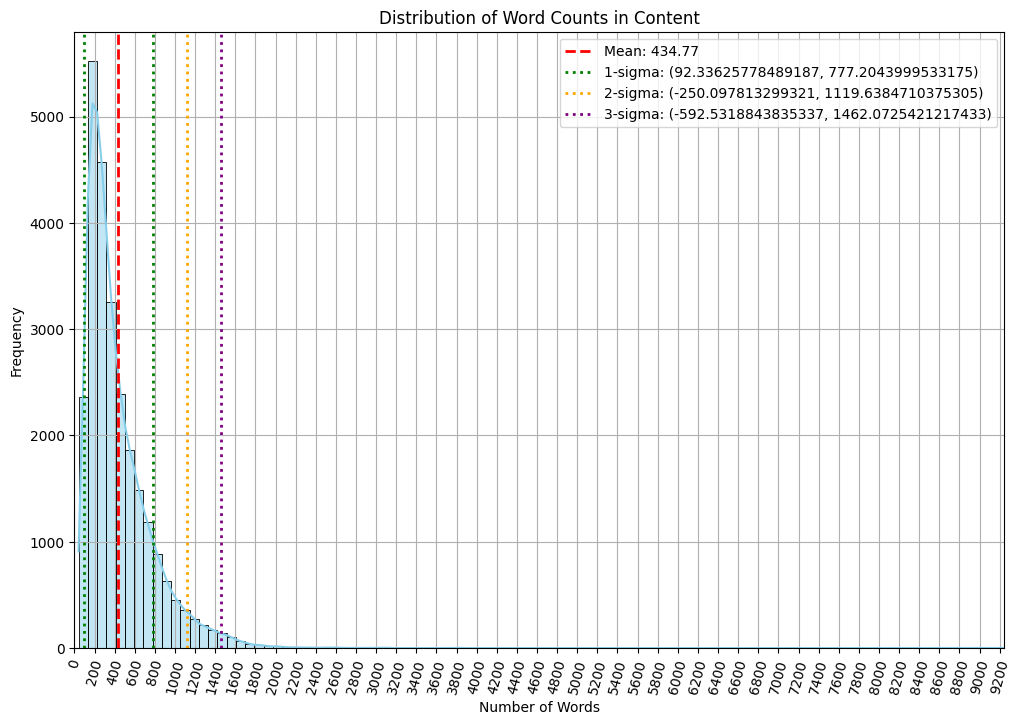

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculate word count
converted_df['word_count'] = converted_df['content'].apply(lambda x: len(x.split()))

# Calculate mean and standard deviation
mean_word_count = converted_df['word_count'].mean()
std_word_count = converted_df['word_count'].std()

# Calculate 1-sigma, 2-sigma, and 3-sigma intervals
one_sigma_interval = (mean_word_count - std_word_count, mean_word_count + std_word_count)
two_sigma_interval = (mean_word_count - 2 * std_word_count, mean_word_count + 2 * std_word_count)
three_sigma_interval = (mean_word_count - 3 * std_word_count, mean_word_count + 3 * std_word_count)

# Display the intervals
print(f"Mean number of words in the content: {mean_word_count:.2f}")
print(f"1-sigma interval: {one_sigma_interval}")
print(f"2-sigma interval: {two_sigma_interval}")
print(f"3-sigma interval: {three_sigma_interval}")

# Plot the distribution of word counts
plt.figure(figsize=(12, 8))
sns.histplot(converted_df['word_count'], bins=100, kde=True, color='skyblue', edgecolor='black')
plt.axvline(mean_word_count, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_word_count:.2f}')

# Highlight 1-sigma, 2-sigma, and 3-sigma intervals
plt.axvline(one_sigma_interval[0], color='green', linestyle='dotted', linewidth=2, label=f'1-sigma: {one_sigma_interval}')
plt.axvline(one_sigma_interval[1], color='green', linestyle='dotted', linewidth=2)

plt.axvline(two_sigma_interval[0], color='orange', linestyle='dotted', linewidth=2, label=f'2-sigma: {two_sigma_interval}')
plt.axvline(two_sigma_interval[1], color='orange', linestyle='dotted', linewidth=2)

plt.axvline(three_sigma_interval[0], color='purple', linestyle='dotted', linewidth=2, label=f'3-sigma: {three_sigma_interval}')
plt.axvline(three_sigma_interval[1], color='purple', linestyle='dotted', linewidth=2)

# Customize X-axis labels to appear every 20 units
start = 0
end = converted_df['word_count'].max()
increment = 200
xticks_locations = range(start, int(end) + 1, increment)
plt.xticks(xticks_locations, rotation=75)
plt.xlim(start, end)  # Ensure the plot shows the entire data

plt.title('Distribution of Word Counts in Content')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
encode_contents = tokenizer.texts_to_sequences(converted_df['content'])
contents_max_length = max([len(el) for el in encode_contents])


In [24]:
VOCAB_SIZE = len(tokenizer.word_index)
MAX_LEN = contents_max_length

In [25]:
encode_contents = pad_sequences(encode_contents, maxlen=MAX_LEN, padding='post')

In [26]:
X_test_contents = tokenizer.texts_to_sequences(converted_test_df['content'])
contents_test_max_length = max([len(el) for el in X_test_contents])
X_test_contents = pad_sequences(X_test_contents, maxlen=MAX_LEN, padding='post')

In [22]:
# One-hot y
y = converted_df['label']
y_test = converted_test_df['label']
# Create the one-hot encoder
enc = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Fit the encoder on the category names
enc.fit(np.array(y).reshape(-1, 1))
y = enc.transform(np.array(y).reshape(-1, 1))
y_test = enc.transform(np.array(y_test).reshape(-1, 1))

# Save to Json and Json file
category_to_one_hot_dict = dict(zip(list(range(enc.categories_[0].shape[0])), enc.categories_[0]))

In [41]:
with open("saved_models/label_dict.json", "w") as file:
    json.dump(category_to_one_hot_dict, file)
file.close()

In [27]:

X_train_contents, X_val_contents, y_train, y_val = train_test_split(
    encode_contents,  # Contents feature
    y, stratify=y,
    test_size=0.2,
    random_state=12345
)


In [28]:
def convert_to_datast_tensor(X_contents, yy):

  return tf.convert_to_tensor(X_contents, dtype=tf.int32),\
          tf.convert_to_tensor(yy, dtype=tf.float64)

In [29]:
# prompt: create tensorfrom slice ((X_train_title, X_train_summary,X_train_contents), y
BATCH_SIZE = 92

train_dataset = tf.data.Dataset.from_tensor_slices((X_train_contents, y_train)).\
                      map(convert_to_datast_tensor, num_parallel_calls=tf.data.AUTOTUNE).\
                      batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val_contents, y_val)).\
                      map(convert_to_datast_tensor, num_parallel_calls=tf.data.AUTOTUNE).\
                      batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test_contents, y_test)).\
                      map(convert_to_datast_tensor, num_parallel_calls=tf.data.AUTOTUNE).\
                      batch(BATCH_SIZE)

In [18]:
embedding_dim = 192
# VOCAB_SIZE = 
def create_model():
    # Define input layers
    content_input = Input(shape=(MAX_LEN,), name='content_input')
    
    # Define embedding layers (you might need to adjust embedding dimension)    
    content_embedding = tf.keras.layers.Embedding(VOCAB_SIZE,                                                  
                                                  embedding_dim,
                                                  # weights = [embedding_matrix],
                                                  trainable=True)(content_input)
    
    content_lstm = Bidirectional(GRU(64, return_sequences=True))(content_embedding)
    # content_lstm = LSTM(64, return_sequences=True)(content_embedding)
    content_lstm = Dropout(0.2)(content_lstm)
    content_lstm = BatchNormalization()(content_lstm)
    
    content_lstm = Bidirectional(GRU(64, return_sequences=False))(content_lstm)
    # content_lstm = LSTM(220, return_sequences=False)(content_lstm)
    content_lstm = Dropout(0.2)(content_lstm)
    content_lstm = BatchNormalization()(content_lstm)
    
    # Define dense layers for classification
    dense1 = Dense(192, activation='relu')(content_lstm)
    dropout = Dropout(0.2)(dense1)
    output = Dense(y_train.shape[1], activation='softmax')(dense1)  # Output layer with softmax
    
    # Create the model
    model = Model(inputs=content_input, outputs=output)

    return model

In [24]:
model = create_model()
# model = create_model_rnn()
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
              loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ content_input (InputLayer)           │ (None, 8054)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, 8054, 192)           │      36,264,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 8054, 128)           │          99,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 8054, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 8054, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 128)                 │          74,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 192)                 │          24,768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 8)                   │           1,544 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 36,465,096 (139.10 MB)

 Trainable params: 36,464,584 (139.10 MB)

 Non-trainable params: 512 (2.00 KB)

In [22]:
# !rm -rf saved_models

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [25]:
# Callback
os.makedirs("saved_models/weights", exist_ok=True)
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5,
    mode="min", restore_best_weights=True),
    tf.keras.callbacks.BackupAndRestore(
    backup_dir='saved_models/weights', delete_checkpoint=False
    )
]

In [ ]:
# del model

In [26]:
history = model.fit(train_dataset,
          epochs=15, callbacks=my_callbacks,
          validation_data=val_dataset)

Epoch 1/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 399s 2s/step - accuracy: 0.4486 - loss: 1.5151 - val_accuracy: 0.6278 - val_loss: 1.5007
Epoch 2/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 391s 2s/step - accuracy: 0.9490 - loss: 0.1674 - val_accuracy: 0.8421 - val_loss: 0.4998
Epoch 3/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 390s 2s/step - accuracy: 0.9944 - loss: 0.0269 - val_accuracy: 0.9290 - val_loss: 0.2553
Epoch 4/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 391s 2s/step - accuracy: 0.9983 - loss: 0.0104 - val_accuracy: 0.9382 - val_loss: 0.2394
Epoch 5/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 391s 2s/step - accuracy: 0.9989 - loss: 0.0067 - val_accuracy: 0.9390 - val_loss: 0.2410
Epoch 6/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 391s 2s/step - accuracy: 0.9990 - loss: 0.0049 - val_accuracy: 0.9392 - val_loss: 0.2485
Epoch 7/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 391s 2s/step - accuracy: 0.9992 - loss: 0.0031 - val_accuracy: 0.9367 - val_loss: 0.2728
Epoch 8/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 390s 2s/step - accuracy: 0.9997 - loss: 0.0021 - val_accu

## Save Model

In [31]:
model.save('saved_models/bidirectional-GRU.h5')

# Evaluation

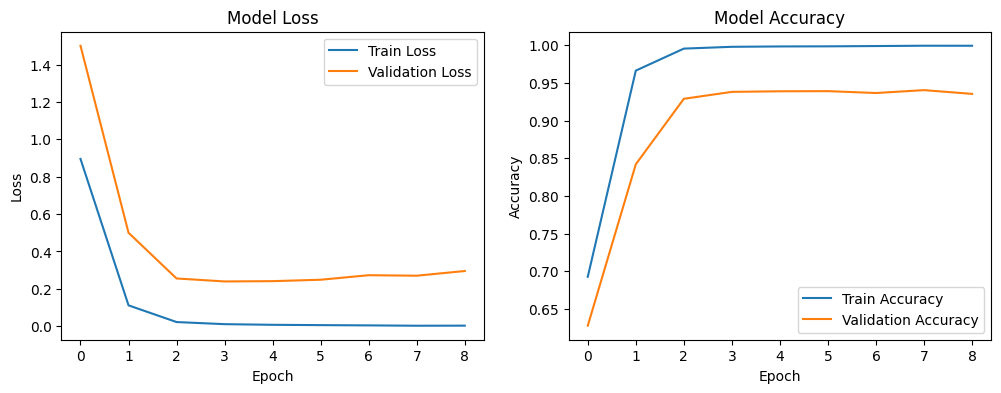

In [27]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.show()

In [28]:
val_loss, val_acc = model.evaluate(val_dataset)
print(f"Loss of Validation set: {val_loss}, Accuracy of Validation set: {val_acc}")

57/57 ━━━━━━━━━━━━━━━━━━━━ 36s 629ms/step - accuracy: 0.9372 - loss: 0.2545
Loss of Validation set: 0.23940232396125793, Accuracy of Validation set: 0.9382194876670837


In [29]:
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Loss of Test set: {test_loss}, Accuracy of Test set: {test_acc}")

27/27 ━━━━━━━━━━━━━━━━━━━━ 17s 618ms/step - accuracy: 0.6614 - loss: 1.7429
Loss of Test set: 1.171366810798645, Accuracy of Test set: 0.7616666555404663


# Inference

In [6]:
import re

## Load Model

In [7]:
# Load Model
model = tf.keras.models.load_model('saved_models/bidirectional-GRU.h5')

## Load Tokenizer

In [10]:
# Load Exists Tokenizers

tokenizer_file = open('tokenizers/tokenizer.pkl', 'rb')
tokenizer = pickle.load(tokenizer_file)

tokenizer = tf.keras.preprocessing.text.tokenizer_from_json(tokenizer)

## Load Label Dict

In [ ]:
# Load the JSON file back into a dictionary
with open("saved_models/label_dict.json", 'r', encoding='utf-8') as file:
    label_dict = json.load(file)
file.close()

## Real News Inference

In [ ]:
MAX_LEN = 8054
characters_to_replace = r'!"#$%&()*+,-./:;=?@\[\\\]^`{|}~\t\n'

In [56]:
# Ground Truth: The thao
content = """
Liverpool và Chelsea cùng mất điểm.
Toàn bộ các đại gia ra sân ở vòng 21 Premier League sáng 15-1 đều bị cầm hòa. Trong đó, Liverpool và Chelsea phải rất vất vả mới lấy lại được 1 điểm.
Liverpool và Chelsea cùng mất điểm.
Liverpool (phải) vất vả giành lại 1 điểm từ tay Nottingham Forest

Liverpool phải làm khách trước đội bóng duy nhất đánh bại họ ở Premier League mùa này là Nottingham Forest. Được xem là "ngựa ô" của mùa giải năm nay, Nottingham Forest chỉ kém ngôi đầu bảng của Liverpool có 6 điểm. Và họ hoàn toàn có thể tham gia cuộc đua vô địch.

Nỗi sợ với CĐV "lữ đoàn đỏ" tái hiện rất sớm. Ngay phút thứ 8, Nottingham Forest ghi bàn mở tỉ số với pha lên bóng đầu tiên của họ.

Liverpool và Chelsea cùng mất điểm.
Wood ghi bàn mở tỉ số từ sớm.

Từ một pha tranh chấp giữa sân, Elanga có bóng rồi chọc khe cho Chris Wood thoát xuống dứt điểm ở góc khá hẹp. Tiền đạo người New Zealand vẫn tung được cú dứt điểm hiểm hóc, hạ gục thủ thành Alisson.

Trước và sau bàn thua này, Liverpool hoàn toàn làm chủ thế trận. Dù vậy, các chân sút của họ bất lực trong việc tạo ra cơ hội trước hàng thủ chơi quá chắc chắn của Nottingham Forest.

Liverpool và Chelsea cùng mất điểm.
Liverpool đỉnh bảng, Man United vẫn hạng 14 sau nửa mùa Giải Ngoại hạng Anh.
ĐỌC NGAY
Độ nguy hiểm của Nottingham Forest cũng khiến các cầu thủ phòng ngự Liverpool không dám dâng cao. Vì vậy, Liverpool đành chấp nhận tỉ số 0-1 sau 45 phút đầu tiên.

Liverpool tăng tốc ở hiệp 2 như dự đoán, và bước ngoặt đến từ pha thay người ở phút 66 của HLV Arne Slot. Hai cầu thủ được tung vào sân là Tsimikas và Jota lập công ngay trong cú chạm bóng đầu tiên của họ.

Liverpool và Chelsea cùng mất điểm
Jota ghi bàn gỡ hòa

Trên chấm phạt góc, Tsimikas tạt bóng chuẩn xác để Jota ập vào đánh đầu cận thành tung lưới đối thủ, ghi bàn gỡ hòa.

Sau bàn thắng này, trận đấu cũng cởi mở hơn khi Nottingham Forest bắt đầu dâng cao đội hình. Nhờ vậy, Liverpool tạo ra hàng loạt cơ hội ăn bàn.

Khá nhàn hạ trong hiệp 1, thủ thành Matz Sels trở thành tâm điểm của hiệp 2 với một chuỗi những pha cứu thua khó tin. Chỉ trong khoảng 20 phút cuối trận, thủ thành người Bỉ liên tiếp từ chối 4 cơ hội ghi bàn mười mươi của Jota, Salah và Gakpo.

Nottingham Forest còn gặp may khi cú sút cực căng của Salah sau tình huống phạt góc cuối trận bị hậu vệ Ola Aina phá ngay trước vạch vôi.

Không thể ghi thêm bàn thắng, Liverpool chấp nhận chia điểm với Nottingham Forest. Liverpool hiện có 47 điểm nhưng mới đá 20 trận, nhiều hơn 6 điểm so với vị trí nhì bảng của chính Nottingham Forest (đá 21 trận).

Liverpool không phải quá lo lắng bởi cả hai đại gia cùng ra sân sáng 15-1 là Man City và Chelsea đều bị cầm hòa. Riêng Chelsea phải rất vất vả mới có thể giành lại 1 điểm dù được đá trên sân nhà trước Bournemouth.

Chelsea mở đầu trận đấu với kịch bản vô cùng quen thuộc. Cole Palmer tỏa sáng ghi bàn mở tỉ số, để rồi hàng thủ kém cỏi khiến họ phải trả giá.

Liverpool và Chelsea cùng mất điểm
Tình huống ghi bàn gỡ hòa của Chelsea
Từ phút 50 đến 68, Bournemouth ghi liền 2 bàn để dẫn lại 2-1. Chelsea chơi tấn công dồn dập trong những phút cuối trận và cũng có được bàn gỡ hòa nhờ pha sút phạt đẳng cấp của Reece James.

Với trận hòa này, Chelsea mới có 37 điểm sau 21 trận, kém Liverpool 10 điểm và chỉ hơn đội hạng 5 là Newcastle vỏn vẹn 2 điểm. Chelsea có thể văng khỏi top 4 nếu Newcastle thắng vòng đấu này.

"""

content = re.sub(f"[{re.escape(characters_to_replace)}]", "", content.replace("\n", " "))
content = "<sos> "+ word_tokenize(content.replace("\n", ""), format="text") + " <eos>"
content = tokenizer.texts_to_sequences([content])
content = pad_sequences(content, maxlen=MAX_LEN, padding='post')
content_predict = model.predict(content, verbose=0)
result = np.argmax(content_predict, axis=1)
print(f"Type of this news is: {label_dict[str(result[0])]}")

Type of this news is: The thao
